# Librerias y Dataset

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import twitter_samples
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from gensim.models import KeyedVectors
data = pd.read_csv('archivos/sentimientos.csv')


Using TensorFlow backend.


In [2]:
representacionVectorial = KeyedVectors.load_word2vec_format('archivos/fasttext-sbwc.3.6.e20.vec', limit=100000)

# Codificación vectorial que mantiene la secuencia

## Codificar Tweet 

In [3]:
max_words=1380
#encoded_strings = [keras.preprocessing.text.one_hot(d, max_words) for d in data['A']]
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=max_words, lower=True, char_level=False)
tokenizer.fit_on_texts(data['A'])  #leaky
encoded_strings = tokenizer.texts_to_sequences(data['A'])
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
encoded_strings = keras.preprocessing.sequence.pad_sequences(encoded_strings, maxlen=10000)

tokenizing input data...
dictionary size:  1380


## Codificar Etiqueta

In [4]:
#encoder = preprocessing.LabelEncoder()
#encoder.fit(data['B'])
#encoded_labels = encoder.transform(data['B'])
encoded_labels = pd.get_dummies(data, columns = ["B"])
encoded_labels =encoded_labels[['B_negativo','B_neutral','B_positivo']]

## Split Datos

In [5]:
X_train, X_test, y_train, y_test = train_test_split(encoded_strings, encoded_labels, test_size=0.2, random_state=1)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

## Adaptando longitudes de los vectores de cada texto

In [6]:
#max_length = 10000
#X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_length, padding='post')
#X_test_padded = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_length, padding='post')

In [7]:
print('preparing embedding matrix...')
embed_dim = 300
words_not_found = []
nb_words = min(max_words, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    if word in representacionVectorial:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = representacionVectorial[word]
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 297


## Red con primera capa de embedding

In [16]:
network = keras.models.Sequential()
network.add(keras.layers.Embedding(max_words,embed_dim, weights=[embedding_matrix], input_length=10000,trainable=False))
network.add(keras.layers.Flatten())
network.add(keras.layers.Dense(units=50, activation='relu'))
network.add(keras.layers.Dense(units=3, activation='sigmoid'))

## Compilar red con clasificación binaria

In [17]:
network.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

## Entrenar Red y visualizar resultados

In [18]:
history = network.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
acc_hist = history.history['accuracy']
val_acc_hist = history.history['val_accuracy']
val_acc_loss = history.history['loss']

Train on 623 samples, validate on 156 samples
Epoch 1/50
623/623 [==============================] - 28s 45ms/sample - loss: 0.7471 - accuracy: 0.7384 - val_loss: 0.6096 - val_accuracy: 0.7821
Epoch 2/50
623/623 [==============================] - 26s 42ms/sample - loss: 0.5713 - accuracy: 0.7416 - val_loss: 0.6078 - val_accuracy: 0.7821
Epoch 3/50
623/623 [==============================] - 26s 42ms/sample - loss: 0.4838 - accuracy: 0.7544 - val_loss: 0.6044 - val_accuracy: 0.7821
Epoch 4/50
623/623 [==============================] - 26s 42ms/sample - loss: 0.3922 - accuracy: 0.8395 - val_loss: 0.5946 - val_accuracy: 0.7628
Epoch 5/50
623/623 [==============================] - 26s 42ms/sample - loss: 0.2944 - accuracy: 0.9053 - val_loss: 0.6099 - val_accuracy: 0.7821
Epoch 6/50
623/623 [==============================] - 26s 42ms/sample - loss: 0.2363 - accuracy: 0.9406 - val_loss: 0.6706 - val_accuracy: 0.7949
Epoch 7/50
623/623 [==============================] - 26s 42ms/sample - loss: 

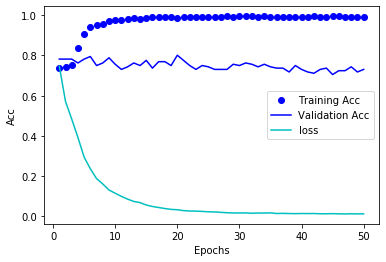

In [19]:
epochs = range(1, len(acc_hist) + 1)
plt.plot(epochs, acc_hist, 'bo', label='Training Acc')
plt.plot(epochs, val_acc_hist, 'b', label='Validation Acc')
plt.plot(epochs, val_acc_loss, 'c', label='loss')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()